In [1]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

In [2]:
%%time
dtype = {
    'userID': 'Int16',
    'answerCode': 'Int8',
    'KnowledgeTag': 'Int16'
}   

DATA_PATH = '/opt/ml/input/data'

TRAIN_DATA_PATH = DATA_PATH + '/train_data.csv'
TEST_DATA_PATH = DATA_PATH + '/test_data.csv'
# DATA_PATH = '/opt/ml/input/data/train_data.csv'
df_train = pd.read_csv(TRAIN_DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df_test = pd.read_csv(TEST_DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])

df = pd.concat([df_train, df_test])
df.sort_values(by=['userID', 'Timestamp'], axis=0, inplace=True)

CPU times: user 9.23 s, sys: 624 ms, total: 9.86 s
Wall time: 9.86 s


## 최근 문제 정답률 영향력

사용자가 푼 문제 전체에 대해 보는 것이 아니라, 가장 최근에 푼 몇 문제에 대한 정답률이 마지막 문제의 정답여부에 영향을 줄 수 있는지 탐색

해당 피처 탐색에서는 마지막 문제에 대한 정답여부가 있는 Train 데이터만 이용하고, 마지막 데이터는 분리

In [3]:
df_train = pd.read_csv(TRAIN_DATA_PATH, dtype=dtype)
df_train.sort_values(by=['userID', 'Timestamp'], axis=0, inplace=True)

df_train_last = df_train.groupby('userID').last().reset_index()
df_train_except_last = df_train.drop(index=list(df_train.reset_index().groupby('userID').last().reset_index().loc[:, 'index']))

In [4]:
# 마지막 데이터를 제외한 데이터셋
df_train_except_last.sample(5)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
1633387,2868,A060093003,A060000093,0,2020-08-06 11:12:33,10403
984890,1474,A030010002,A030000010,1,2020-03-03 07:25:33,7307
1320671,2129,A050161003,A050000161,1,2020-08-26 07:03:40,446
1821290,3442,A070051011,A070000051,0,2020-05-15 06:12:54,6785
1701211,3049,A070129008,A070000129,1,2020-11-14 03:28:50,9066


In [5]:
# 마지막 데이터
df_train_last.tail()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
6693,7436,A030019001,A030000019,0,2020-04-08 12:07:21,331
6694,7437,A060003007,A060000003,0,2020-05-22 01:53:49,7226
6695,7438,A030188005,A030000188,1,2020-10-19 10:28:29,1934
6696,7440,A030197005,A030000197,0,2020-10-21 08:33:20,1984
6697,7441,A040165004,A040000165,1,2020-08-21 01:08:49,8836


최근 n문제에 대한 정답률을 구해주는 함수

In [6]:
def recent_last_n(n, df_train, df_train_last):
  recent_percentile = df_train.groupby('userID')['answerCode'].rolling(n).mean().reset_index()
  recent_last_n = recent_percentile.groupby('userID').last().reset_index()
  recent_last_n.rename(columns={'answerCode': 'answerPercentile'}, inplace=True)
  recent_last_n = pd.concat([recent_last_n, df_train_last['answerCode']], axis=1)
  return recent_last_n

In [7]:
recent_dict = {'recent': [], 'gt_50': [], 'lt_50': []}
for i in range(3, 10, 2):
  recent_dict['recent'].append(i)
  recent_last = recent_last_n(i, df_train_except_last, df_train_last)
  gt_50 = recent_last[recent_last['answerPercentile'] > 0.5]
  lt_50 = recent_last[recent_last['answerPercentile'] < 0.5]
  recent_dict['gt_50'].append(round(gt_50[gt_50['answerCode'] == 1].count()['userID'] / gt_50.count()['userID'], 3) * 100)
  recent_dict['lt_50'].append(round(lt_50[lt_50['answerCode'] == 0].count()['userID'] / lt_50.count()['userID'], 3) * 100)

recent_df = pd.DataFrame(recent_dict)
recent_df

,recent,gt_50,lt_50
0,3,62.1,74.6
1,5,61.8,76.5
2,7,60.7,75.5
3,9,59.7,74.5


<AxesSubplot:xlabel='recent', ylabel='gt_50'>

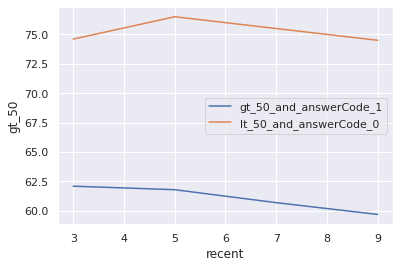

In [8]:
sns.lineplot(data=recent_df, x='recent', y='gt_50', label='gt_50_and_answerCode_1')
sns.lineplot(data=recent_df, x='recent', y='lt_50', label='lt_50_and_answerCode_0')

gt_50_answerCode_1은 최근 정답률이 50% 이상이면서 마지막 문제를 맞췄을 확률, lt_50_answerCode_0은 최근 정답률이 50% 미만이면서 마지막 문제를 못 맞췄을 확률이다.

따라서 gt_50_answerCode_1은 클수록, lt_50_answerCode_0은 작을 수록 최근 문제의 정답률이 마지막 문제에 주는 영향력이 크다고 할 수 있다.  

그래프를 보면 알 수 있듯이 최근 문제 정답률에 대한 윈도우 사이즈가 커질 수록 마지막 문제에 대한 정답 여부를 예측하기 어려워짐을 알 수 있다. 하지만 윈도우 사이즈 5에서 gt_50_answerCode_1이 가장 큰 것으로 보아 적정 윈도우 사이즈가 5일 가능성이 있다.

## 마지막 문제의 태그가 주는 영향력

In [9]:
user_group = df_train.groupby(['userID', 'KnowledgeTag']).agg(maxTagCount=('userID', 'count')).reset_index()
user_group = user_group.groupby('userID').max().reset_index()
user_max = pd.concat([user_group, df_train.groupby(['userID']).agg(totalTagCount=('KnowledgeTag', 'count')).reset_index()['totalTagCount']], axis=1)
user_max['percent'] = user_max['maxTagCount'] / user_max['totalTagCount']
user_max

,userID,KnowledgeTag,maxTagCount,totalTagCount,percent
0,0,10606,15,745,0.020134
1,1,11271,36,933,0.038585
2,2,7823,11,276,0.039855
3,5,10749,18,833,0.021609
4,6,11265,17,921,0.018458
...,...,...,...,...,...
6693,7436,7321,6,15,0.400000
6694,7437,7226,7,16,0.437500
6695,7438,4605,5,16,0.312500
6696,7440,10328,5,15,0.333333


In [10]:
user_count = []
for i in zip(list(df_train['userID'].unique()), list(df_train.reset_index().groupby('userID').last().loc[:, 'KnowledgeTag'])):
    user_count.append(df_train[(df_train['userID'] == i[0]) & (df_train['KnowledgeTag'] == i[1])].count()['userID'])

In [11]:
user_max['lastTagCount'] = user_count
user_max['lastTagCountByMaxTag'] = user_max['lastTagCount'] / user_max['maxTagCount']
user_max['answerCode'] = df_train_last['answerCode']
user_max

,userID,KnowledgeTag,maxTagCount,totalTagCount,percent,lastTagCount,lastTagCountByMaxTag,answerCode
0,0,10606,15,745,0.020134,4,0.266667,0
1,1,11271,36,933,0.038585,6,0.166667,1
2,2,7823,11,276,0.039855,7,0.636364,0
3,5,10749,18,833,0.021609,4,0.222222,1
4,6,11265,17,921,0.018458,10,0.588235,0
...,...,...,...,...,...,...,...,...
6693,7436,7321,6,15,0.400000,2,0.333333,0
6694,7437,7226,7,16,0.437500,7,1.000000,0
6695,7438,4605,5,16,0.312500,5,1.000000,1
6696,7440,10328,5,15,0.333333,5,1.000000,0


In [12]:
tag_dict = {'percentile': [], 'count': []}
for i in range(5, 11):
  tag_dict['percentile'].append(i*10)
  tag_count = user_max[user_max['lastTagCountByMaxTag'] >= i * 0.1].groupby('answerCode').agg(count=('userID', 'count')).reset_index()
  tag_sum = tag_count.loc[0, 'count'] + tag_count.loc[1, 'count']
  tag_dict['count'].append(round((tag_count.loc[1, 'count'] / tag_sum), 3) * 100)
tag_df = pd.DataFrame(tag_dict)
tag_df

,percentile,count
0,50,49.6
1,60,49.7
2,70,50.3
3,80,48.9
4,90,49.2
5,100,49.4


Text(0, 0.5, 'Last Question Answer Percentile')

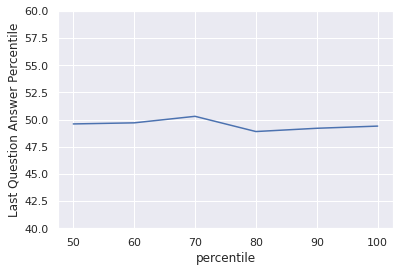

In [18]:
sns.lineplot(data=tag_df, x='percentile', y='count')
plt.ylim(40, 60)
plt.ylabel("Last Question Answer Percentile")

위의 그래프에서 볼 수 있다시피 가장 많이 풀린 태그와 비교했을 때 마지막 문제와 같은 태그를 갖는 문제들이 풀린 횟수와 마지막 문제의 정답률 사이에는 상관관계를 찾을 수 없었다.

가장 많이 푼 태그와의 비교가 아닌 절대적인 개수로 비교. 4분위수를 확인했을 때 3분위(75%)에 위치한 값이 6임을 알 수 있다.
그러므로 마지막 문제의 태그와 같은 태그를 가진 문제가 6개 이상 풀렸다면 꽤 많이 풀렸다고 가정할 수 있다. 따라서 기준을 6개 이상으로 잡고 접근.

In [19]:
user_max['lastTagCount'].describe()

count    6698.000000
mean        5.489251
std         3.268661
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        36.000000
Name: lastTagCount, dtype: float64

In [24]:
tag_dict ={'tag_count': [], 'answer_percentile': []}
for i in range(6, 30):
    tag_dict['tag_count'].append(i)
    tag_count = user_max[user_max['lastTagCount'] >= i].groupby('answerCode').agg(count=('userID', 'count')).reset_index()
    tag_sum = tag_count.loc[0, 'count'] + tag_count.loc[1, 'count']
    tag_dict['answer_percentile'].append(round((tag_count.loc[1, 'count'] / tag_sum), 3) * 100)
tag_df = pd.DataFrame(tag_dict)
tag_df

,tag_count,answer_percentile
0,6,48.8
1,7,49.9
2,8,51.7
3,9,52.0
4,10,50.9
5,11,51.1
6,12,50.3
7,13,48.3
8,14,46.6
9,15,48.2


(40.0, 70.0)

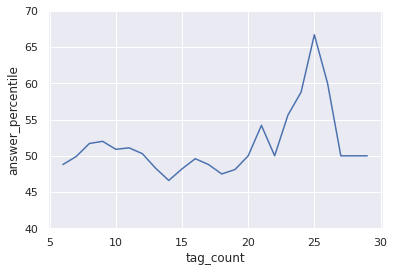

In [26]:
sns.lineplot(data=tag_df, x='tag_count', y='answer_percentile')
plt.ylim(40, 70)

딱히 어떤 상관관계를 찾기는 힘들었지만 25개일 때 정답률이 높아지는 현상이 관찰되었다.  
해당 피처를 탐색해보았더니 이는 단지 푼 문제의 대략 90%가 마지막 문제의 태그와 같았기 때문이었다.  
따라서 마지막 문제와 같은 태그를 지닌 문제를 많이 풀었다고 정답여부에 영향을 준다기 보다는 보다 전체적으로 보았을 때 특정 문제와 같은 태그를 많이 풀수록 해당 문제를 더 잘 맞힐 가능성이 있다.

In [27]:
user_max[user_max['lastTagCount'] == 25]

,userID,KnowledgeTag,maxTagCount,totalTagCount,percent,lastTagCount,lastTagCountByMaxTag,answerCode
245,271,10749,30,1368,0.021930,25,0.833333,1
1432,1595,10573,27,410,0.065854,25,0.925926,1
